<a href="https://colab.research.google.com/github/ayush29feb/nn-experiments/blob/master/gan/GAN_Normal_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks

The hello world implementation of a GAN on normal distribution.

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x57808000 @  0x7f102d4db2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

## The Distributation or Data

In [0]:
# p_data
def get_distribution_sampler(mu, sigma):
  return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))

## The Input Noise

In [0]:
# p_z
def get_generator_input_sampler():
  return lambda m, n: torch.rand(m, n)

## Generator Model

In [0]:
class Generator(nn.Module):
  
  def __init__(self, input_size, hidden_size, output_size):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)
  
  def forward(self, x):
    x = F.elu(self.fc1(x))
    x = F.sigmoid(self.fc2(x))
    return self.fc3(x)

## Discriminator

In [0]:
class Discriminator(nn.Module):
  
  def __init__(self, input_size, hidden_size, output_size):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)
  
  def forward(self, x):
    x = F.elu(self.fc1(x))
    x = F.elu(self.fc2(x))
    return F.sigmoid(self.fc3(x))

## Training

In [0]:
# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 1     # Random noise dimension coming into generator, per output vector
g_hidden_size = 200   # Generator complexity
g_output_size = 1    # size of generated output vector
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = d_input_size

d_learning_rate = 2e-4  # 2e-4
g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)
num_epochs = 100000
print_interval = 1000
d_steps = 2  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

In [8]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

(name, preprocess, d_input_func) = ("Data and variances", 
                                    lambda data: decorate_with_diffs(data, 2.0), 
                                    lambda x: x * 2)
print("Using data [%s]" % (name))

Using data [Data and variances]


In [0]:
d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

In [33]:
for epoch in range(num_epochs):
  for d_index in range(d_steps):
      # 1. Train D on real+fake
      D.zero_grad()

      #  1A: Train D on real
      d_real_data = Variable(d_sampler(d_input_size))
      d_real_decision = D(preprocess(d_real_data))
      d_real_error = criterion(d_real_decision, Variable(torch.ones(1)))  # ones = true
      d_real_error.backward() # compute/store gradients, but don't change params

      #  1B: Train D on fake
      d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
      d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
      d_fake_decision = D(preprocess(d_fake_data.t()))
      d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1)))  # zeros = fake
      d_fake_error.backward()
      d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

  for g_index in range(g_steps):
      # 2. Train G on D's response (but DO NOT train D on these labels)
      G.zero_grad()

      gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
      g_fake_data = G(gen_input)
      dg_fake_decision = D(preprocess(g_fake_data.t()))
      g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))  # we want to fool, so pretend it's all genuine

      g_error.backward()
      g_optimizer.step()  # Only optimizes G's parameters

  if epoch % print_interval == 0:
      print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                          extract(d_real_error)[0],
                                                          extract(d_fake_error)[0],
                                                          extract(g_error)[0],
                                                          stats(extract(d_real_data)),
                                                          stats(extract(d_fake_data))))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0: D: 0.5446030497550964/0.6588071584701538 G: 0.7254208922386169 (Real: [4.134171104431152, 1.25382824308548], Fake: [0.2031211343407631, 0.008612423031194668]) 
1000: D: 0.9001461863517761/0.6355764865875244 G: 0.7067381739616394 (Real: [4.095482776165008, 1.0724833863207737], Fake: [4.213295823335647, 1.41217722384139]) 
2000: D: 0.40529218316078186/0.7221962809562683 G: 0.7925741076469421 (Real: [3.8889312171936035, 1.3911485790298999], Fake: [4.067434405088425, 1.423882481481717]) 
3000: D: 0.4498905539512634/1.3052579164505005 G: 1.2587599754333496 (Real: [3.9061478322744367, 1.2866357012644554], Fake: [4.5232876944541935, 1.18820025648093]) 
4000: D: 0.3557259142398834/0.3032849431037903 G: 0.9478645920753479 (Real: [4.026519832015038, 1.2784669763517256], Fake: [3.7200016283988955, 1.2984260717499654]) 
5000: D: 0.6917238831520081/0.2571312189102173 G: 0.8296079039573669 (Real: [4.204291694164276, 1.2524679206200786], Fake: [3.5022759845852853, 1.3226325442801923]) 
6000: D: 0.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


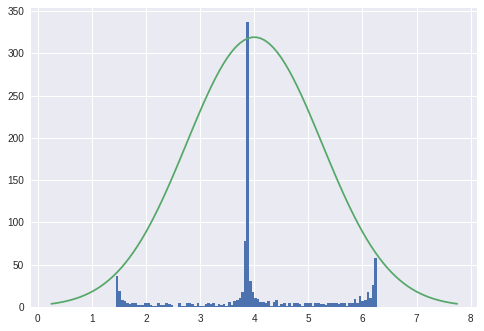

In [48]:
# Lets plot the outputs and see if the distribution learned by the generator is
# actually the normal distribution we were trying to learn?
z = Variable(gi_sampler(1000, g_input_size))
x = G(z)

samples = x.detach().numpy()
plt.hist(samples, bins=100)
x = np.linspace(data_mean - 3*data_stddev, data_mean + 3*data_stddev, 100)
plt.plot(x,1000 * mlab.normpdf(x, data_mean, data_stddev))